In [53]:
import pandas as pd
import numpy as np

import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from matplotlib import pyplot
from numpy import cov
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

In [3]:
data = pd.read_excel('/Users/garywang/Downloads/NPTranData.xlsx')

In [4]:
data.info() # Check null value 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103347 entries, 0 to 103346
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   trnOpDate        103347 non-null  int64
 1   staCode          103347 non-null  int64
 2   gateInComingCnt  103347 non-null  int64
 3   gateOutGoingCnt  103347 non-null  int64
dtypes: int64(4)
memory usage: 3.2 MB


In [5]:
# Q1
def top3_staCode_in(data):
    # Group datas by 'staCode' and sum up 'gateInComingCnt' by each group. 
    data1 = data[['staCode','gateInComingCnt']].groupby(['staCode'], as_index = False).sum()
    # Sort values by 'gateInComingCnt' and find which 'staCode' are top 3 number of clients go into station.
    data1 = data1.sort_values(by = 'gateInComingCnt', ascending = False, ignore_index = True)
    staCode1 = data1['staCode'][0]
    staCode2 = data1['staCode'][1]
    staCode3 = data1['staCode'][2]
    return staCode1, staCode2, staCode3

In [6]:
top3_staCode_in(data)

(1000, 1080, 1100)

In [7]:
# Q2
def top3_staCode_out(data):
    # Group datas by 'staCode' and sum up 'gateOutGoingCnt' by each group. 
    data2 = data[['staCode','gateOutGoingCnt']].groupby(['staCode'], as_index = False).sum()
    # Sort values by 'gateOutGoingCnt' and find which 'staCode' are top 3 number of clients out of station.
    data2 = data2.sort_values(by = 'gateOutGoingCnt', ascending = False, ignore_index = True)
    staCode1 = data1['staCode'][0]
    staCode2 = data1['staCode'][1]
    staCode3 = data1['staCode'][2]
    return staCode1, staCode2, staCode3

In [8]:
top3_staCode_in(data)

(1000, 1080, 1100)

In [9]:
# Q3
data_diff = data
# Generate new feature 'gateDiffCnt' and deal with 'trnOpDate' to become year+month format.
for i in range(len(data_diff)):
    data_diff.loc[i,'gateDiffCnt'] = abs(data_diff.loc[i,'gateInComingCnt'] - data_diff.loc[i,'gateOutGoingCnt'])
    data_diff.loc[i,'trnOpDate'] = data_diff.loc[i,'trnOpDate']//100

# Group 'staCode' and 'trnOpDate' to find the flow of customers for each station in every month.    
dataMonth = data_diff.groupby(['staCode','trnOpDate']).sum()
dataMonth

gateInComingCnt  gateOutGoingCnt  gateDiffCnt
staCode trnOpDate                                               
900     201904               67693            63678       4015.0
        201905              256178           239728      16450.0
        201906              258489           230870      27965.0
        201907              264650           221442      43208.0
        201908              256300           214089      42211.0
...                            ...              ...          ...
7390    202002               10118            10288        500.0
        202003               10610            11093        865.0
        202004                9840            10546        854.0
        202005               10901            11895       1058.0
        202006               11413            12177        856.0

[3586 rows x 3 columns]

In [10]:
# Find maxium of 'gateDiffCnt'
dataMonth[dataMonth['gateDiffCnt']==dataMonth['gateDiffCnt'].max()]

,,gateInComingCnt,gateOutGoingCnt,gateDiffCnt
staCode,trnOpDate,,,
1000,202001,1894584,1851622,155102.0


In [11]:
# Q4
# Choose 'staCode'==1000 and 'trnOpDate'==201911 being our example.
temp = data_diff[data_diff['staCode']==1000]
temp = temp[temp['trnOpDate']==201911]
temp.describe()

,trnOpDate,staCode,gateInComingCnt,gateOutGoingCnt,gateDiffCnt
count,30.0,30.0,30.000000,30.000000,30.000000
mean,201911.0,1000.0,65260.166667,64511.100000,2982.333333
std,0.0,0.0,7236.995900,5959.048694,2293.129143
min,201911.0,1000.0,56761.000000,56640.000000,386.000000
25%,201911.0,1000.0,59128.000000,59088.750000,923.250000
50%,201911.0,1000.0,61048.000000,64066.000000,2292.500000
75%,201911.0,1000.0,71997.000000,69612.250000,5084.250000
max,201911.0,1000.0,77361.000000,76778.000000,7955.000000


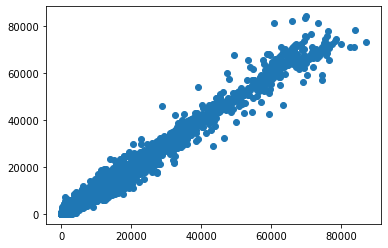

In [12]:
# Q5
# Check relationship between 'gateInComingCnt' and 'gateOutGoingCnt'
pyplot.scatter(data_diff['gateInComingCnt'], data_diff['gateOutGoingCnt'])
pyplot.show()

In [13]:
# Covariance
cov(data_diff['gateInComingCnt'], data_diff['gateOutGoingCnt'])

array([[34753845.86487687, 34606425.15917953],
       [34606425.15917953, 34771000.29411459]])

In [14]:
# Pearson’s Correlation
pearsonr(data_diff['gateInComingCnt'], data_diff['gateOutGoingCnt'])

(0.9955124858084519, 0.0)

In [15]:
# Q6
# Separate training and testing data
dataTrain = data_diff[data_diff['trnOpDate']<=202004]
dataTest = data_diff[data_diff['trnOpDate']>=202005]

In [35]:
# Normalize
xTrain = np.array(dataTrain['gateInComingCnt']).reshape((-1,1))
yTrain = np.array(dataTrain['gateOutGoingCnt'])
xMean = np.mean(xTrain)
xStd = np.sqrt(np.var(xTrain))
yMean = np.mean(yTrain)
yStd = np.sqrt(np.var(yTrain))
xTrain = (xTrain-xMean)/xStd
yTrain = (yTrain-yMean)/yStd

In [39]:
# Linear model
model = LinearRegression(fit_intercept=True)
model.fit(xTrain, yTrain)

xTest = np.array(dataTest['gateInComingCnt']).reshape((-1,1))
yTest = np.array(dataTest['gateOutGoingCnt'])
xTest = (xTest-xMean)/xStd
yfit = model.predict(xTest)
yfit = yfit * yStd + yMean
MSE = sum((yfit - yTest)**2)/len(yTest)
print(MSE)

275902.98149433115


In [52]:
# LightGBM
d_train = lgb.Dataset(xTrain, label= yTrain)
param = {'num_leaves': 70, 'objective': 'regression', 'metric': 'rmse', 'maxdepth': 20, 'boosting_type': 'gbdt',
        'learning_rate': 0.05}
num_round = 50
bst = lgb.train(param, d_train, num_round)


y_pred = bst.predict(xTest)
y_pred = y_pred * yStd + yMean
MSE = sum((y_pred - yTest)**2)/len(yTest)
print(MSE)

592481.2167742811
